# CNN Transfer Learning - Feature Extraction

## Transfer Learning

- A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task
- We either use the pretrained model as is or use transfer learning to customize this model to a given task

### Intuition

- The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world
- We can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

### Two ways to customize a pretrained model

- Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples
    - We simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
    - We do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures
    - However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.
- Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model
    - This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

![Transfer Learning](https://www.researchgate.net/publication/359405075/figure/fig2/AS:1182999492214798@1659060466845/Concept-of-fine-tuning-and-feature-extraction.png)

# Import Libraries

In [1]:
# Base Packages
import os
import time
import random
import zipfile

# EDA packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Scikit-learn
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics as sklearn_metrics

# Tensorflow & Keras packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

In [2]:
tf.__version__

'2.6.2'

# Load Data

In [3]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

## Unzip Data

In [4]:
# zip_ref = zipfile.ZipFile('./10_food_classes_all_data.zip', 'r')
# zip_ref.extractall()
# zip_ref.close()

## A walk with data

In [5]:
for dirpath, dirnames, filenames in os.walk('./10_food_classes_all_data/'):
  print(f'Current Path {dirpath} ----- No. of directories {len(dirnames)} ----- No. of files {len(filenames)}')

Current Path ./10_food_classes_all_data/ ----- No. of directories 2 ----- No. of files 0
Current Path ./10_food_classes_all_data/test ----- No. of directories 10 ----- No. of files 0
Current Path ./10_food_classes_all_data/test/chicken_curry ----- No. of directories 0 ----- No. of files 250
Current Path ./10_food_classes_all_data/test/chicken_wings ----- No. of directories 0 ----- No. of files 250
Current Path ./10_food_classes_all_data/test/fried_rice ----- No. of directories 0 ----- No. of files 250
Current Path ./10_food_classes_all_data/test/grilled_salmon ----- No. of directories 0 ----- No. of files 250
Current Path ./10_food_classes_all_data/test/hamburger ----- No. of directories 0 ----- No. of files 250
Current Path ./10_food_classes_all_data/test/ice_cream ----- No. of directories 0 ----- No. of files 250
Current Path ./10_food_classes_all_data/test/pizza ----- No. of directories 0 ----- No. of files 250
Current Path ./10_food_classes_all_data/test/ramen ----- No. of director

In [6]:
DATA_DIR = '10_food_classes_all_data'
TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'
IMAGE_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

# Viz Data

In [7]:
def render_random_image(data_path, title):

    random_image = random.sample(os.listdir(data_path), 1)[0]
    random_image_path = mpimg.imread(data_path+random_image)
    plt.imshow(random_image_path)
    plt.title(title)
    plt.axis('off')
    return random_image_path

In [8]:
food_classes = os.listdir('./10_food_classes_all_data/train')

'ramen'

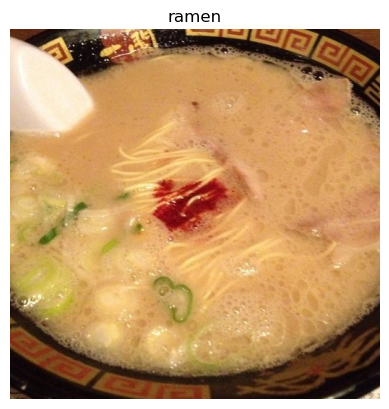

In [9]:
rand_choice = random.choice(food_classes)
render_random_image(f'{TRAIN_DIR}/{rand_choice}/', rand_choice)
rand_choice

# Pre-Process Image Data

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
# Rescale
train_datagen = ImageDataGenerator(rescale=1/255., 
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load Data
train_data = train_datagen.flow_from_directory(TRAIN_DIR,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               subset='training',
                                               class_mode='categorical')

# Load Data
valid_data = train_datagen.flow_from_directory(TRAIN_DIR,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               subset='validation',
                                               class_mode='categorical')

test_data = test_datagen.flow_from_directory(TEST_DIR,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='categorical')

Found 6000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# CNN Model - Transfer Learning

In [13]:
import tensorflow_hub as hub

In [14]:
inception_v3_feature_vector = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5'
efficientnet_feature_vector = 'https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1'

In [15]:
def create_model(model_url, num_class=10):
    
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name='featire_extraction_layer',
                                             input_shape=IMAGE_SHAPE)
    
    model = keras.Sequential([
        feature_extractor_layer,
        keras.layers.Dense(num_class, activation=keras.activations.softmax)
    ])

In [16]:
inception_model = create_model(inception_v3_feature_vector)

2023-07-08 18:46:34.417917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-08 18:46:34.417963: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-08 18:46:34.417986: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4c7153f4cc0e): /proc/driver/nvidia/version does not exist
2023-07-08 18:46:34.419209: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
